In [ ]:
# import opendatasets as od
# import os
# DATA_DIR = '../data/raw/vlsp'

# if not os.path.exists(DATA_DIR):
#   os.makedirs(DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/test-en", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/test-vi", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/val-en", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/val-vi", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/train-en", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/train-vi", data_dir=DATA_DIR)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/nguyenanhtu164/test-en


100%|██████████| 419k/419k [00:00<00:00, 596kB/s]


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/nguyenanhtu164/test-vi


100%|██████████| 442k/442k [00:00<00:00, 599kB/s]


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/nguyenanhtu164/val-en


100%|██████████| 430k/430k [00:00<00:00, 580kB/s]


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/nguyenanhtu164/val-vi


100%|██████████| 455k/455k [00:00<00:00, 612kB/s]


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/nguyenanhtu164/train-en


100%|██████████| 15.0M/15.0M [00:02<00:00, 6.83MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/nguyenanhtu164/train-vi


100%|██████████| 15.9M/15.9M [00:02<00:00, 7.58MB/s]


In [ ]:
# !pip install pyvi --quiet

import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from pyvi import ViTokenizer

nltk.download('punkt')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

INPUT_PATHS = {
    "train": {
        "en": "/raw/vlsp/train-en/train.en.txt",
        "vi": "/raw/vlsp/train-vi/train.vi.txt"
    },
    "val": { 
        "en": "/raw/vlsp/val-en/val.en.new.txt",
        "vi": "/raw/vlsp/val-vi/val.vi.new.txt"
    },
    "test": { 
        "en": "/raw/vlsp/test-en/test.en.new.txt",
        "vi": "/raw/vlsp/test-vi/test.vi.new.txt"
    }
}

OUTPUT_DIR = "../data/med-ev"
os.makedirs(OUTPUT_DIR, exist_ok=True)

d:\nlp-project\.venv\Lib\site-packages\pyvi\ViTokenizer.py:24: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  model = pickle.load(fin)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def tokenize_en(text):
    return nltk.word_tokenize(str(text).strip().lower())

def tokenize_vi(text):
    text = str(text).strip().lower()
    text = ViTokenizer.tokenize(text)
    return text.split()

def build_vocab_from_tokens(token_lists, min_freq=2):
    counter = Counter()
    
    for tokens in token_lists:
        counter.update(tokens)
    
    vocab = {
        "<unk>": 0,
        "<pad>": 1,
        "<s>": 2,
        "</s>": 3
    }
    
    idx = 4
    for word, freq in counter.most_common():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
            
    return vocab

def save_json(data, filename):
    with open(f"{OUTPUT_DIR}/{filename}", "w", encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False)

In [ ]:
all_train_en_tokens = []
all_train_vi_tokens = []

eda_stats = {'train': {}, 'val': {}, 'test': {}}

for split_name in ["train", "val", "test"]:
    print(f"\nProcessing {split_name}...")
    
    path_en = INPUT_PATHS[split_name]["en"]
    path_vi = INPUT_PATHS[split_name]["vi"]

    with open(path_en, 'r', encoding='utf-8') as f:
        raw_en = f.readlines()
    with open(path_vi, 'r', encoding='utf-8') as f:
        raw_vi = f.readlines()
        
    assert len(raw_en) == len(raw_vi), f"Lỗi ở tập {split_name}"

    lines_en_tokens = [tokenize_en(line) for line in raw_en]
    lines_vi_tokens = [tokenize_vi(line) for line in raw_vi]
    
    eda_stats[split_name]['en_len'] = [len(t) for t in lines_en_tokens]
    eda_stats[split_name]['vi_len'] = [len(t) for t in lines_vi_tokens]

    lines_en_str = [" ".join(tokens) for tokens in lines_en_tokens]
    lines_vi_str = [" ".join(tokens) for tokens in lines_vi_tokens]
    
    df = pd.DataFrame({'en': lines_en_str, 'vi': lines_vi_str})
    save_path = f"{OUTPUT_DIR}/{split_name}.csv"
    df.to_csv(save_path, index=False)
    
    if split_name == "train":
        all_train_en_tokens = lines_en_tokens
        all_train_vi_tokens = lines_vi_tokens

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


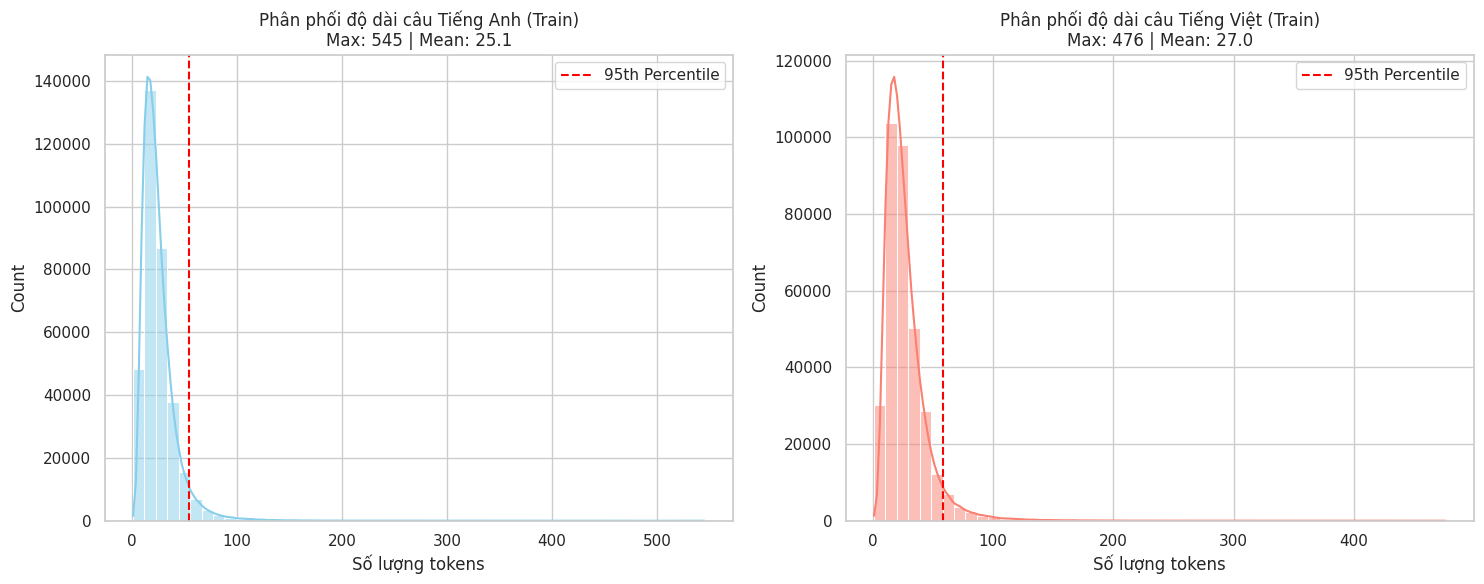

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


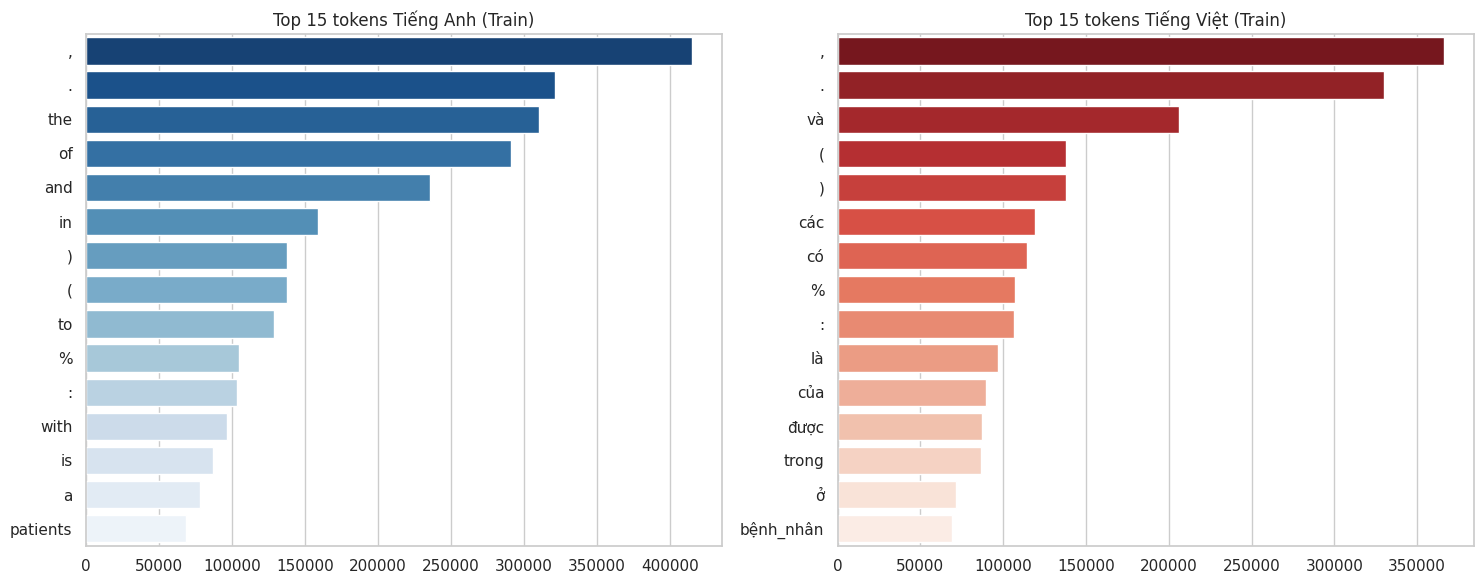

In [ ]:
train_en_len = eda_stats['train']['en_len']
train_vi_len = eda_stats['train']['vi_len']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(train_en_len, bins=50, color='skyblue', kde=True, ax=axes[0])
axes[0].set_title(f"Phân phối độ dài câu Tiếng Anh (Train)\nMax: {max(train_en_len)} | Mean: {np.mean(train_en_len):.1f}")
axes[0].set_xlabel("Số lượng tokens")
axes[0].axvline(np.percentile(train_en_len, 95), color='red', linestyle='--', label='95th Percentile')
axes[0].legend()

sns.histplot(train_vi_len, bins=50, color='salmon', kde=True, ax=axes[1])
axes[1].set_title(f"Phân phối độ dài câu Tiếng Việt (Train)\nMax: {max(train_vi_len)} | Mean: {np.mean(train_vi_len):.1f}")
axes[1].set_xlabel("Số lượng tokens")
axes[1].axvline(np.percentile(train_vi_len, 95), color='red', linestyle='--', label='95th Percentile')
axes[1].legend()

plt.tight_layout()
plt.show()

def plot_top_words(tokens_list, title, ax, color):
    all_tokens = [t for sent in tokens_list for t in sent]
    counter = Counter(all_tokens)
    common = counter.most_common(15)
    words = [x[0] for x in common]
    counts = [x[1] for x in common]
    sns.barplot(x=counts, y=words, ax=ax, palette=color)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_top_words(all_train_en_tokens, "Top 15 tokens Tiếng Anh (Train)", axes[0], "Blues_r")
plot_top_words(all_train_vi_tokens, "Top 15 tokens Tiếng Việt (Train)", axes[1], "Reds_r")
plt.tight_layout()
plt.show()

In [ ]:
en_vocab = build_vocab_from_tokens(all_train_en_tokens, min_freq=2)
vi_vocab = build_vocab_from_tokens(all_train_vi_tokens, min_freq=2)

en_id2token = {v: k for k, v in en_vocab.items()}
vi_id2token = {v: k for k, v in vi_vocab.items()}

save_json(en_vocab, "en_token2id.json")
save_json(vi_vocab, "vi_token2id.json")
save_json(en_id2token, "en_id2token.json")
save_json(vi_id2token, "vi_id2token.json")

print(f"EN: {len(en_vocab)}")
print(f"VI: {len(vi_vocab)}")

EN: 69025
VI: 45864
